<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imitation-learning" data-toc-modified-id="Imitation-learning-1">Imitation learning</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.2">Preparing the data</a></span><ul class="toc-item"><li><span><a href="#Code" data-toc-modified-id="Code-1.2.1">Code</a></span></li><li><span><a href="#Loading" data-toc-modified-id="Loading-1.2.2">Loading</a></span></li></ul></li><li><span><a href="#Creating-the-model" data-toc-modified-id="Creating-the-model-1.3">Creating the model</a></span><ul class="toc-item"><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-1.3.1">Building the model</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.4">Train</a></span><ul class="toc-item"><li><span><a href="#Trainings" data-toc-modified-id="Trainings-1.4.1">Trainings</a></span></li></ul></li><li><span><a href="#Summary-of-first-improvements" data-toc-modified-id="Summary-of-first-improvements-1.5">Summary of first improvements</a></span></li><li><span><a href="#Summary-of-second-improvements" data-toc-modified-id="Summary-of-second-improvements-1.6">Summary of second improvements</a></span></li></ul></li></ul></div>

# Imitation learning

On this notebook I will try to improve the agent using the ideas of the second iteration.

## Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import glob
import os
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig

## Preparing the data

### Code

In [2]:
def load_games_data(game_filepaths):
    data = [np.load(game_filepath) for game_filepath in tqdm(game_filepaths, desc='Loading recorded games')]
    ohe = OneHotEncoder(categories=[range(3)], sparse=False)
    previous_action = np.concatenate([game['previous_action'] for game in data], axis=0)[:, 0]
    ohe.fit(previous_action[:, 1:2])
    previous_action = [ohe.transform(previous_action[:, 0:1]), ohe.transform(previous_action[:, 1:2])]
    previous_action = np.concatenate(previous_action, axis=1)
    model_input = {
        'frame': np.concatenate([game['frame'] for game in data], axis=0),
        'speed': np.concatenate([game['speed'] for game in data], axis=0)[:, 0]/10,
        'previous_action': previous_action,
    }
    action = np.concatenate([game['action'] for game in data], axis=0)
    model_output = {
        'action_move': ohe.transform(action[:, 0:1]),
        'action_rotate': ohe.transform(action[:, 1:2]),
    }
    return model_input, model_output

In [3]:
def mirror_game(game_data):
    return _mirror_input_data(game_data[0]), _mirror_output_data(game_data[1])
    
def _mirror_input_data(input_data):
    mirror_input_data = input_data.copy()
    mirror_input_data['frame'] = np.flip(mirror_input_data['frame'], axis=2)
    mirror_input_data['previous_action'] = mirror_input_data['previous_action'][:, [0, 1, 2, 3, 5, 4]]
    return mirror_input_data

def _mirror_output_data(output_data):
    mirror_output_data = output_data.copy()
    mirror_output_data['action_rotate'] = mirror_output_data['action_rotate'][:, [0, 2, 1]]
    return mirror_output_data

In [4]:
def duplicate_games(game_data):
    mirror_game_data = mirror_game(game_data)
    input_data, output_data = {}, {}
    for key in game_data[0]:
        input_data[key] = np.concatenate([game_data[0][key], mirror_game_data[0][key]], axis=0)
    for key in game_data[1]:
        output_data[key] = np.concatenate([game_data[1][key], mirror_game_data[1][key]], axis=0)
    return input_data, output_data

### Loading

In [5]:
game_filepaths = glob.glob(os.path.join('/media/guillermo/Data/Kaggle/animalai/gameplay', '*', '*.npz'))

game_filepaths = sorted(game_filepaths)
np.random.seed(7)
np.random.shuffle(game_filepaths)
len(game_filepaths)

223

In [6]:
val_idx = 1
val_filepaths = game_filepaths[val_idx::5]
train_filepaths = [game for game in game_filepaths if game not in val_filepaths]
train = load_games_data(train_filepaths)
val = load_games_data(val_filepaths)

train = duplicate_games(train)
val = duplicate_games(val)

print('Number of train samples: %i' % len(train[0]['frame']))
print('Number of validation samples: %i' % len(val[0]['frame']))


Number of train samples: 23140
Number of validation samples: 6700


## Creating the model

The idea is to process the frame using a lenet like network and merge it later with speed and previous move to take a decision over the actions.

![](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)

### Building the model

In [7]:
def build_model(conv_filters, mlp_units):
    frame = Input(shape=(84, 84, 3), name='frame')
    output = frame
    for n_filters in conv_filters:
        output = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu')(output)
        if int(output.get_shape()[1]) >= 2:
            output = MaxPool2D()(output)
    output = Flatten()(output)
    
    speed = Input(shape=(3), name='speed')
    previous_action = Input(shape=(6), name='previous_action')
    
    output = Concatenate()([output, speed, previous_action])
    
    for n_units in mlp_units:
        output = Dense(n_units, activation='relu')(output)
    
    action_move = Dense(3, activation='softmax', name='action_move')(output)
    action_rotate = Dense(3, activation='softmax', name='action_rotate')(output)
    
    model = Model(inputs=dict(frame=frame, speed=speed, previous_action=previous_action), outputs=[action_move, action_rotate])
    return model

## Train

In [8]:
def train_model(conv_filters, mlp_units):
    model = build_model(conv_filters, mlp_units)
    model.summary()
    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='loss', patience=2, factor=0.7, verbose=1)
    ]
    hist = model.fit(x=train[0], y=train[1], epochs=500, validation_data=val, callbacks=callbacks)
    plot_hist(hist.history)
    return model
    
def plot_hist(hist):
    plt.figure(figsize=(25, 5))
    keys = ['loss']
    for key in keys:
        prefix = ''
        label = '%s%s' % (prefix, key)
        best_score = np.min(hist[label])
        plt.plot(hist[label], label='%s %.4f' % (label, best_score))
        print('%s %.4f' % (label, best_score))
        
        plt.twinx()
        prefix = 'val_'
        label = '%s%s' % (prefix, key)
        best_score = np.min(hist[label])
        plt.plot(hist[label], label='%s %.4f' % (label, best_score), color='orange')
        print('%s %.4f' % (label, best_score))
    plt.legend(loc=0)

### Trainings

W0722 18:40:54.130225 139863416227648 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 41, 41, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 39, 39, 8)    584         max_pooling2d[0][0]              
______________________________________________________________________________________________

23140/23140 [==============================] - 5s 223us/sample - loss: 0.5167 - action_move_loss: 0.2481 - action_rotate_loss: 0.2695 - action_move_acc: 0.9030 - action_rotate_acc: 0.9003 - val_loss: 0.5913 - val_action_move_loss: 0.2941 - val_action_rotate_loss: 0.2966 - val_action_move_acc: 0.8912 - val_action_rotate_acc: 0.8927
Epoch 14/500
23140/23140 [==============================] - 5s 223us/sample - loss: 0.5099 - action_move_loss: 0.2437 - action_rotate_loss: 0.2657 - action_move_acc: 0.9052 - action_rotate_acc: 0.9008 - val_loss: 0.6012 - val_action_move_loss: 0.2996 - val_action_rotate_loss: 0.3016 - val_action_move_acc: 0.8887 - val_action_rotate_acc: 0.8876
Epoch 15/500
23140/23140 [==============================] - 5s 225us/sample - loss: 0.5056 - action_move_loss: 0.2418 - action_rotate_loss: 0.2636 - action_move_acc: 0.9042 - action_rotate_acc: 0.9010 - val_loss: 0.5978 - val_action_move_loss: 0.2977 - val_action_rotate_loss: 0.2997 - val_action_move_acc: 0.8872 - val_a

Epoch 37/500
23140/23140 [==============================] - 5s 230us/sample - loss: 0.4356 - action_move_loss: 0.2091 - action_rotate_loss: 0.2261 - action_move_acc: 0.9170 - action_rotate_acc: 0.9137 - val_loss: 0.6515 - val_action_move_loss: 0.3347 - val_action_rotate_loss: 0.3167 - val_action_move_acc: 0.8921 - val_action_rotate_acc: 0.8870
Epoch 00037: early stopping
loss 0.4356
val_loss 0.5758


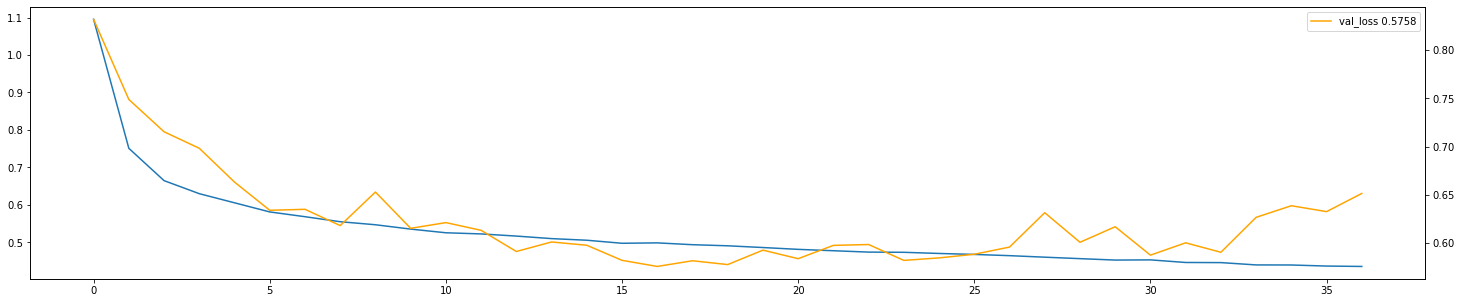

In [9]:
args = [8, 8, 16, 16], [16]
model = train_model(*args)
#model.save('/media/guillermo/Data/Kaggle/animalai/agents/004_better_agent/data/model.hdf')
model.save('/media/guillermo/Data/Kaggle/animalai/agents/005_avoid_and_navigation/data/model.hdf')

In [10]:
os.system('spd-say End')

0

## Summary of first improvements

1. I have trained a model just on static and moving green food and the accuracy of the models seems to be much better. It is surprising that with a few games it is able to achieve the best score on the evaluation levels.
2. I have added yellow food, static and moving, the score improves a lot, from 0.74 to 0.97.
3. Remove condition for stopped agent. The results are not conclusive but worse
4. Fix bug in rotation stop condition. The results are not conclusive but worse
5. Improve lights off, I simply don't move when the lights are off. This improves the score
6. Advanced stop rotation condition, move forward n_steps.

I have made a submission and the result is worse than the previous model. This is indicating that the score that I'm getting from evaluation is not well correlated with the leaderboard.

## Summary of second improvements

Now the goal is to improve navigation and learn to avoid dead objects.

The agent should rotate if the space is empty and head to the goal if there is clear path. If there is a dead zone it should navigate and try to circle it.

Dead zones are always located in the floor, so I cannot avoid goals or agents falling into them.

1. Play some games on 4-Avoidance (seed=1)
2. Play more gameson 4-Avoidance (seed=2)
3. Learn to escape from looking to the border, by playing food and restarting until I start playing looking to the border. I have also created a new level were the agent starts at the border so it's easier to gather memories.
4. Remove avoidance levels
5. Add spatial navigation, improves on that level but worsen on others for example chasing red food
6. Add more spatial navigation, I think that navigation is a hard problem and should probably be learned better by RL
7. More playing on border
8. Play on moving food
9. Add avoidance levels again

The problem with the 9th version is that it has some degenerations like going to the border and staying there. I'm goint to try to modify the index assigned to validation to see if we can escape those behaviours. It improves, so I'm going to make a submission and see how it does. 

This is like trying to keep balance, I improve on one category and suddlenly worsen on other. I think the solution to this is reinforcement learning. That way the model could learn not only what it has to do but also what it does not have to do.